Original missing percentage in 'ytrue': 0.00%
Percentage of 1s in mask (should be ~20.0%): 19.94%
Final missing percentage in 'value': 19.94%
Data with missing values saved to: D:\Reproducing the values\MR_at_test\Datasets\MR_20\test_a\505_c1_test_20aAA.csv
Plot saved to: D:\Reproducing the values\MR_at_test\Datasets\MR_20\test_a\505_c1_test_20aAA_plot.png


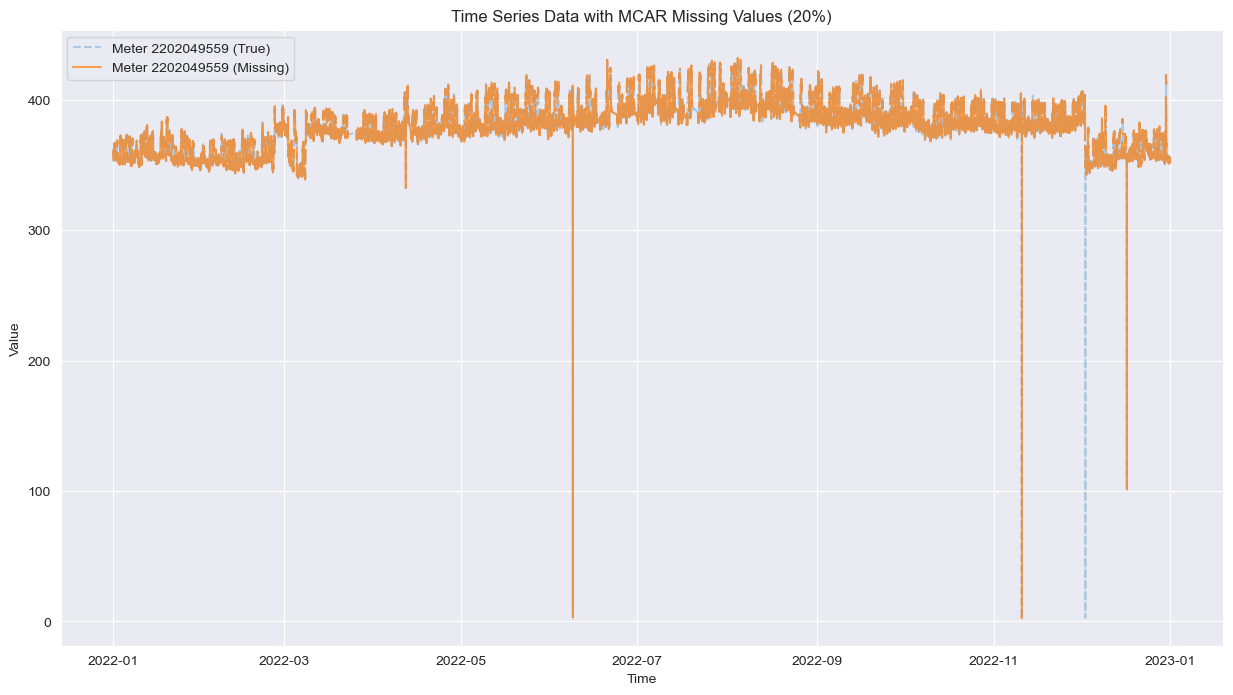

In [10]:
# Code to generate MCAR Missing data for test_505.csv

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os

# Define file paths
input_file_path = r"D:\Reproducing the values\MR_at_test\Datasets\MR_20\test_a\test_505.csv"
output_file_path = r"D:\Reproducing the values\MR_at_test\Datasets\MR_20\test_a\505_c1_test_20aAA.csv"
plot_file_path = r'D:\Reproducing the values\MR_at_test\Datasets\MR_20\test_a\505_c1_test_20aAA_plot.png'

def generate_mcar_missing(data, p_miss):
    """
    Generate missing data using the MCAR mechanism based on the 'ytrue' column.

    Args:
        data (pl.DataFrame): The complete Polars DataFrame with 'ytrue' column.
        p_miss (float): The desired proportion of missing values in the 'value' column.

    Returns:
        pl.DataFrame: The Polars DataFrame with missing values in 'value' using MCAR.
    """
    # Filter out rows where 'ytrue' is null to work with complete data
    data = data.filter(pl.col('ytrue').is_not_null())

    # Calculate original missing percentage in 'ytrue' (should be 0% after filtering)
    original_missing = (data['ytrue'].null_count() / data.height) * 100
    print(f"Original missing percentage in 'ytrue': {original_missing:.2f}%")

    # Generate missing values using a Bernoulli distribution (1 = missing, 0 = present)
    mask = np.random.binomial(1, p_miss, size=data.height)
    mask = pl.from_numpy(mask.astype(bool))

    # Verify mask distribution, extracting scalar value from the sum
    mask_proportion = mask.sum().item() / mask.height * 100  # Use .item() to get scalar
    print(f"Percentage of 1s in mask (should be ~{p_miss*100}%): {mask_proportion:.2f}%")

    # Create a new DataFrame with 'value' column, applying the mask
    data = data.with_columns(
        value=pl.when(mask).then(pl.lit(None)).otherwise(pl.col('ytrue'))  # 'value' gets missing values
    )

    return data

def plot_missing_data(data, save_path):
    """
    Plot the time series data with missing values and save the plot.

    Args:
        data (pl.DataFrame): The Polars DataFrame with missing values.
        save_path (str): Path to save the plot.
    """
    data = data.to_pandas()
    data['datetime'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %H:%M')

    plt.figure(figsize=(15, 8))
    for meter_no in data['meter_no'].unique():
        subset = data[data['meter_no'] == meter_no]
        plt.plot(subset['datetime'], subset['ytrue'], label=f'Meter {meter_no} (True)', alpha=0.3, linestyle='--')
        plt.plot(subset['datetime'], subset['value'], label=f'Meter {meter_no} (Missing)', alpha=0.7)

    plt.title('Time Series Data with MCAR Missing Values (20%)')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    try:
        plt.savefig(save_path)
        print(f"Plot saved to: {save_path}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    plt.show()

# Read the input data with error handling
try:
    data = pl.read_csv(input_file_path)
except Exception as e:
    print(f"Error reading input file: {e}")
    raise

# Generate MCAR missing data with 20% missing values
data_mcar = generate_mcar_missing(data, p_miss=0.2)

# Calculate the missing percentage in the 'value' column
missing_percentage = (data_mcar['value'].null_count() / data_mcar.height) * 100
print(f"Final missing percentage in 'value': {missing_percentage:.2f}%")

# Write the output data to a CSV file with overwrite check
if os.path.exists(output_file_path):
    print(f"Warning: {output_file_path} already exists. Overwriting.")
try:
    data_mcar.write_csv(output_file_path)
    print(f"Data with missing values saved to: {output_file_path}")
except Exception as e:
    print(f"Error writing output file: {e}")
    raise

# Plot the missing data and save the plot
plot_missing_data(data_mcar, plot_file_path)